## Explore peak data

Separate by TF/histone (could even separate further into narrow/broad histones but not sure) and count number of peaks, plot distribution. Also take out phantom peaks and see how number of peaks is affected. 
Flag datasets with less than 100(?) peaks and look into further. 

In [29]:
import pandas as pd
import seaborn as sb
import glob
import os
import pybedtools
from pybedtools.featurefuncs import gff2bed

In [2]:
throw_out = ['ERX242704', 'ERX242706', 'ERX242707','ERX242709', 'ERX242710','ERX242711','ERX242712','ERX242713',
             'ERX242715', 'ERX242716', 'ERX242717', 'ERX242718','ERX242722', 'ERX242723', 'ERX242724', 'ERX242726',
             'ERX242727', 'ERX242728', 'ERX242729']

In [3]:
#look into these
empty = ['SRX495277','SRX495278','SRX495290','SRX495289','SRX326969']

In [4]:
#all peaks would be glob.glob('../chipseq-wf/data/chipseq_peaks/*/[S,E]RX*/peaks.bed')
#macs2 peaks
concat = []
for fname in glob.glob('../chipseq-wf/data/chipseq_peaks/macs2/[S,E]RX*/peaks.bed'):
    name = fname.split('../chipseq-wf/data/chipseq_peaks/macs2/')[1].split('/peaks.bed')[0]
    if name not in throw_out:
        if name not in empty:
            df = pd.read_table(fname, header=None)
            df[1,2] = df[1,2]
            df['srx'] = name
            df['caller'] = 'macs2'
            concat.append(df)
macs2 = pd.concat(concat)

In [40]:
macs2.head()

,0,1,2,3,4,5,6,7,8,srx,9
0,chr2L,16617,16893,SRX191913_peak_1,334,.,6.04012,35.59567,33.40816,SRX191913,NaN
1,chr2L,18490,19713,SRX191913_peak_2,178,.,4.30215,19.78752,17.81555,SRX191913,NaN
2,chr2L,21242,21484,SRX191913_peak_3,79,.,3.16530,9.77751,7.92056,SRX191913,NaN
3,chr2L,34118,34304,SRX191913_peak_4,42,.,2.17206,5.98254,4.27362,SRX191913,NaN
4,chr2L,35499,35830,SRX191913_peak_5,396,.,5.50646,41.82674,39.60189,SRX191913,NaN


In [ ]:
spp_empty = [
SRX149192
SRX885700
ERX402137
ERX402138
SRX885698
SRX883604
SRX1179573
SRX054533
SRX495789
SRX1389384
SRX2055961
SRX2055966
SRX2055958
ERX402108
SRX330269
ERX402133
SRX306190
ERX402112
SRX359797
SRX1433400
SRX306193
ERX1403350
SRX1179572
SRX1433401
SRX018632
SRX1389387
SRX326970
SRX2055964
SRX885702
SRX2055945
SRX326969
SRX447393
SRX330270
SRX495270
SRX2055944
SRX097620
SRX359798
SRX883605
SRX018631
SRX306196
SRX018629
SRX2055953
SRX149189
SRX1389388
SRX018630
SRX1433397
ERX402114
SRX495269
SRX1433399
]

In [6]:
#spp peaks
glob.glob('../chipseq-wf/data/chipseq_peaks/spp/[S,E]RX*/peaks.bed')
concat = []
for fname in glob.glob('../chipseq-wf/data/chipseq_peaks/spp/[S,E]RX*/peaks.bed'):
    name = fname.split('../chipseq-wf/data/chipseq_peaks/spp/')[1].split('/peaks.bed')[0]
    if name not in throw_out:
        if os.path.getsize(fname) != 0:
            df = pd.read_table(fname, header=None)
            df['srx'] = name
            df['caller'] = 'spp'
            concat.append(df)
spp = pd.concat(concat)

In [43]:
spp[[1,2]]= spp[[1,2]].astype(int)
spp.head()

,0,1,2,3,4,5,6,7,8,9,srx
0,chr3L,16052060,16052396,.,0,.,83.161841,-1,3.062582,189,SRX017462
1,chr2R,15847978,15848246,.,0,.,68.046814,-1,3.062582,134,SRX017462
2,chrUn_DS484314v1,1987,2483,.,0,.,65.108303,-1,3.062582,127,SRX017462
3,chr2L,3046627,3047229,.,0,.,63.254780,-1,3.062582,218,SRX017462
4,chrUn_CP007120v1,70331,70564,.,0,.,59.952580,-1,3.062582,127,SRX017462


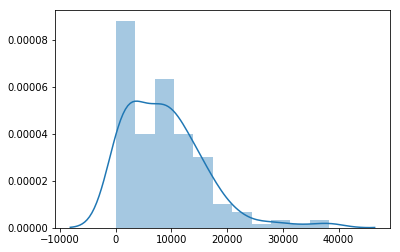

In [20]:
#Count number of peaks per dataset macs2 

peakcount = macs2.groupby('srx')[[1]].count()
sb.distplot(peakcount)

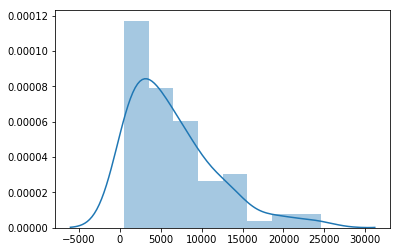

In [21]:
#Count number of peaks per dataset spp
peakcount = spp.groupby('srx')[[1]].count()
sb.distplot(peakcount)

In [44]:
both = pd.concat([macs2, spp])
both.head()

,0,1,2,3,4,5,6,7,8,srx,9
0,chr2L,16617,16893,SRX191913_peak_1,334,.,6.04012,35.59567,33.40816,SRX191913,NaN
1,chr2L,18490,19713,SRX191913_peak_2,178,.,4.30215,19.78752,17.81555,SRX191913,NaN
2,chr2L,21242,21484,SRX191913_peak_3,79,.,3.16530,9.77751,7.92056,SRX191913,NaN
3,chr2L,34118,34304,SRX191913_peak_4,42,.,2.17206,5.98254,4.27362,SRX191913,NaN
4,chr2L,35499,35830,SRX191913_peak_5,396,.,5.50646,41.82674,39.60189,SRX191913,NaN


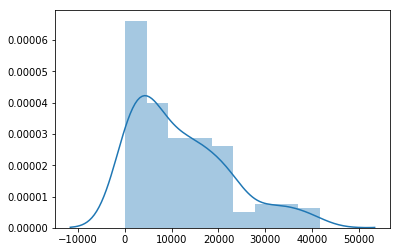

In [25]:
#Count number of peaks per dataset both
peakcount = both.groupby('srx')[[1]].count()
sb.distplot(peakcount)

### Remove phantom peaks

In [27]:
phantompeaks = pd.read_excel(
    '../output/chip/gkv637_Supplementary_Data/Supplementary_table_3__List_of_Phantom_Peaks.xlsx')

In [28]:
phantompeaks = phantompeaks[['chr ','start','end','Name']]

In [59]:
bed = both[[0,1,2,'srx']]

In [70]:
bed = bed[~bed[1].astype(str).str.contains('-')]

In [72]:
intersect = pybedtools.BedTool.from_dataframe(bed).intersect(pybedtools.BedTool.from_dataframe(phantompeaks), 
                                                             wo=True).to_dataframe()

In [75]:
intersect.shape

(130325, 9)

In [76]:
#filter for an overlap of at least 50bp based on Jain et al 2014
filtered = intersect[intersect.itemRgb >= 50]

In [77]:
filtered.shape

(125273, 9)

In [78]:
filtered.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb
0,chr2L,18490,19713,SRX191913,chr2L,18637,19089,Phantom Peak-1,452
1,chr2L,102214,102424,SRX191913,chr2L,102118,102570,Phantom Peak-2,210
2,chr2L,107113,109566,SRX191913,chr2L,107669,108121,Phantom Peak-3,452
3,chr2L,158896,159714,SRX191913,chr2L,158670,159126,Phantom Peak-6,230
4,chr2L,207224,207532,SRX191913,chr2L,207139,207591,Phantom Peak-8,308


In [80]:
bed.columns = ['chrom','start','end','name']

In [82]:
outermerge = bed.merge(filtered, how='outer', on=['chrom','start','end','name'], indicator=True)

In [85]:
no_phantom = outermerge[outermerge._merge == 'left_only'][['chrom','start','end','name']]
no_phantom.head()

,chrom,start,end,name
0,chr2L,16617,16893,SRX191913
2,chr2L,21242,21484,SRX191913
3,chr2L,34118,34304,SRX191913
4,chr2L,35499,35830,SRX191913
5,chr2L,43248,43463,SRX191913


In [86]:
no_phantom.shape

(1953206, 4)